In [1]:
#First, load up things we're definitely going to need
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
from time import time

%matplotlib inline

In [2]:
# Load up the dataset:
dataset = {"car":[], "notcar":[]}
car_dataset_names = ["GTI_Far", "GTI_Left", "GTI_MiddleClose", "GTI_Right", "KITTI_extracted"]
notcar_dataset_names = ["Extras", "GTI"]

for car_dataset in car_dataset_names: dataset['car'] += glob(("./data/vehicles/" + car_dataset) + "/*.png")   
for notcar_dataset in notcar_dataset_names: dataset['notcar'] += glob(("./data/non-vehicles/" + notcar_dataset) + "/*.png")

In [3]:
# Since classifiers tend to favor the class with the majority of examples,
# we need to ensure the classes are properly balanced.
print("Cars:", len(dataset["car"]))
print("Not Cars:", len(dataset["notcar"]))

Cars: 8792
Not Cars: 8968


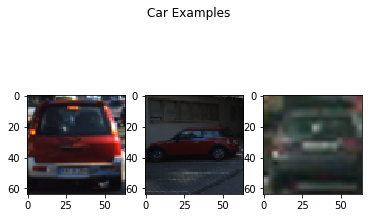

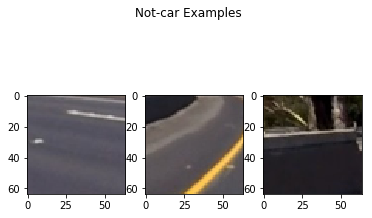

In [4]:
# Load up a couple of random examples of each
example_images_positive = []
example_images_negative = []

# PNGs have scaling issues, so OpenCV loads the images then they get converted to RGB
fig = plt.figure()
fig.suptitle("Car Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3,i + 1)
    img = cv2.imread(dataset['car'][random.randint(0, len(dataset['car']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.imshow(img)

fig = plt.figure()
fig.suptitle("Not-car Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3, i + 1)
    img = cv2.imread(dataset['notcar'][random.randint(0, len(dataset['notcar']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [5]:
# Combine the features and labels into one dataset
features = []
labels = []

for data in dataset['car']:
    features.append(data)
    labels.append("car")

for data in dataset['notcar']:
    features.append(data)
    labels.append("notcar")

# Let's make sure the number of features and labels match up
print("Number of features: " + str(len(features)) + "\nNumber of labels: " + str(len(labels)))

Number of features: 17760
Number of labels: 17760


In [6]:
# Let's split up the dataset into training and test sets

train_imgs, test_imgs, train_original_labels, test_labels = train_test_split(features, labels, test_size=0.25)

print("Number of training images: " + str(len(train_imgs)))
print("Number of test images: " + str(len(test_imgs))) 
print("Train/test split ratio: " + str(len(test_imgs) / (len(test_imgs) + len(train_imgs))))

Number of training images: 13320
Number of test images: 4440
Train/test split ratio: 0.25


In [7]:
# Let's create color histograms of the car to help with identifying what is a vehicle.

# Create the 3D plot for the color histograms
# Credit for this function: Udacity lectures
def plot3d(pixels, colors, axis_limits=((0, 255), (0, 255), (0, 255))):
    
    if colors is not "RGB": pixels = cv2.cvtColor(pixels, getattr(cv2, "COLOR_RGB2" + colors))
    
    axis_labels = colors
    axis_labels = list(axis_labels)
    color_channels = pixels / 255
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=color_channels.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

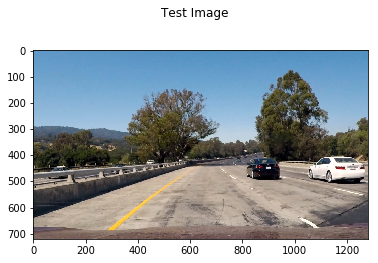

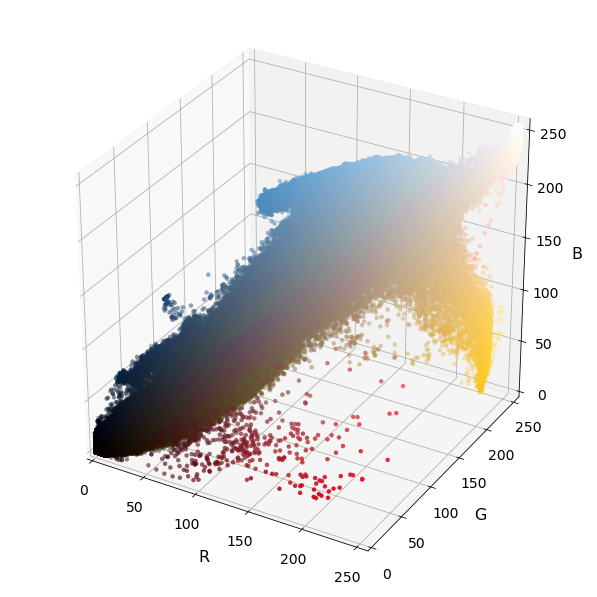

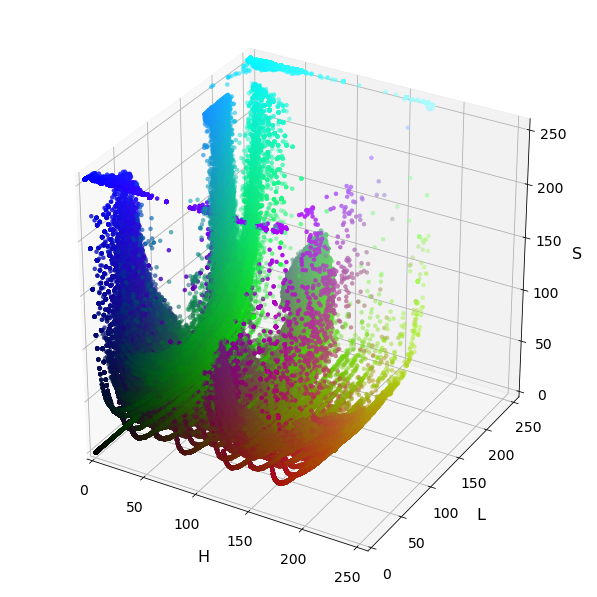

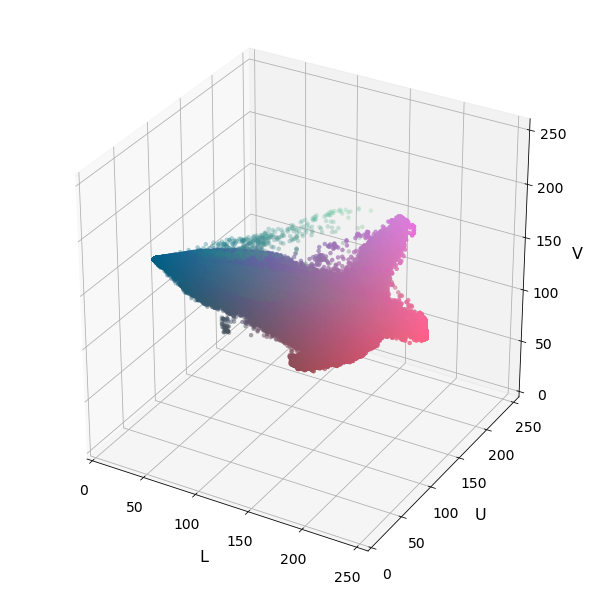

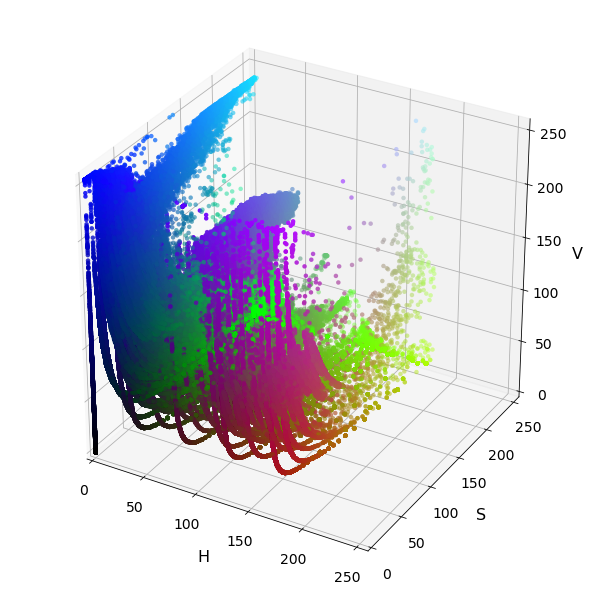

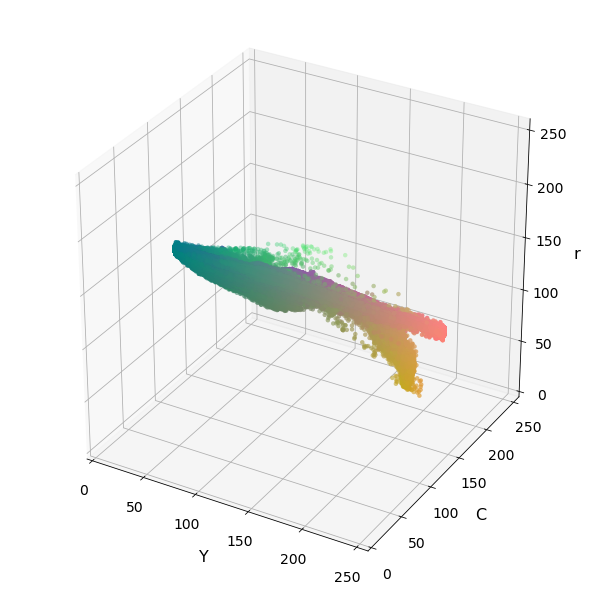

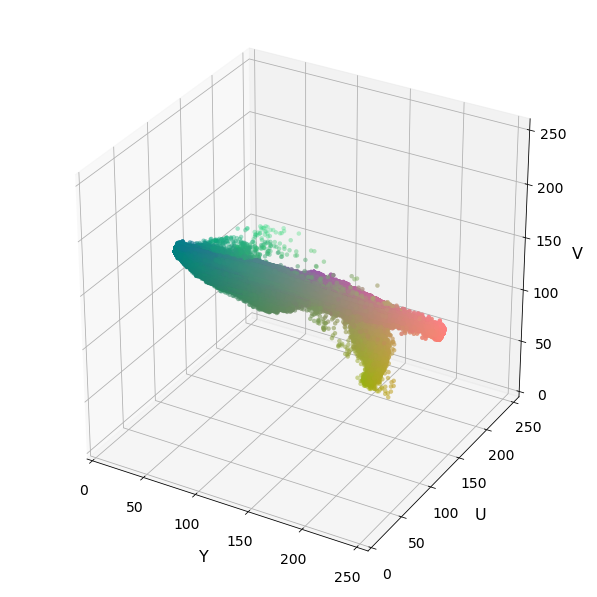

In [8]:
# Load up the test image
test_img = cv2.cvtColor(cv2.imread("./test_images/test1.jpg"), cv2.COLOR_BGR2RGB)

# Show the test image
plt.figure()
plt.suptitle("Test Image")
plt.imshow(test_img)
plt.show()

# Let's explore the color spaces with the 3D plots and see
# which color spaces are the most useful for identifying cars
plot3d(test_img, "RGB")# RGB Colorspace
plot3d(test_img, "HLS")# HLS Colorspace
plot3d(test_img, "LUV")# LUV Colorspace
plot3d(test_img, "HSV")# HSV Colorspace
plot3d(test_img, "YCrCb")# YCrCb Colorspace
plot3d(test_img, "YUV")# YUV Colorspace

The RGB, LUV, YUV, and YCrCb colorspaces don't seem to have any easily distinguishable features between cars and background images. The HLS and HSV colorspaces seem to have identifiable information which could be used to distinguish vehicles.

In [9]:
# To reduce the processing needed, let's reduce the number of features.
# We'll do this by converting the colorspace as needed, resizing the
# image to 32x32, and raveling the image into a 1D feature vector
def bin_spatial(img, color_space, channels_kept=None, size=(32, 32)):
    if color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))

    bins = cv2.resize(img, size)

    if channels_kept is None:
        return bins.ravel()
    else:
        kept_bins = []
        for channel in channels_kept:
            index = color_space.find(channel)
            if index is -1:
                raise Error("The provided channel " + " channel is not found in the color space of " + color_space)

            single_channel = bins[:,:,index]
            kept_bins.append(single_channel.ravel())
            
        #stack the kept_bins together
        return np.concatenate(kept_bins)

In [10]:
# Let's create histograms to generalize color matching for similar cars
def histograms(img, color_space="RGB", channels_kept=None, nbins=32, bins_range=(0, 256)):
    if color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))
        
    if channels_kept is None: channels_kept = color_space
        
    c_indexes = []
    for c in channels_kept: c_indexes.append(color_space.find(c))
    
    channel_histograms = []
    for channel_index in range(0, img.shape[2]):
        if channel_index in c_indexes:
            channel_histogram = np.histogram(img[:,:,channel_index], bins=nbins, range=bins_range)[0]
            channel_histograms.append(channel_histogram)
        
    histogram_features = np.concatenate(channel_histograms)
    
    return histogram_features

In [11]:
# Let's create a Histogram of Oriented Gradients (HOG)
# to create a fingerprint for identifying cars.
def get_hog_features(img,
                     orient=9,
                     pix_per_cell=8,
                     cell_per_block=2,
                     vis=True,
                     color_space="GRAY", 
                     channel_index=0):
    
    if color_space != "GRAY" and color_space != "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))
    
    if vis == True:
        features, hog_image = hog(img[:,:,channel_index],
                                  orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis,
                                  feature_vector=False)
        return features, hog_image
    
    else:
        features = hog(img[:,:,channel_index],
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis,
                       feature_vector=False)
        return features

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


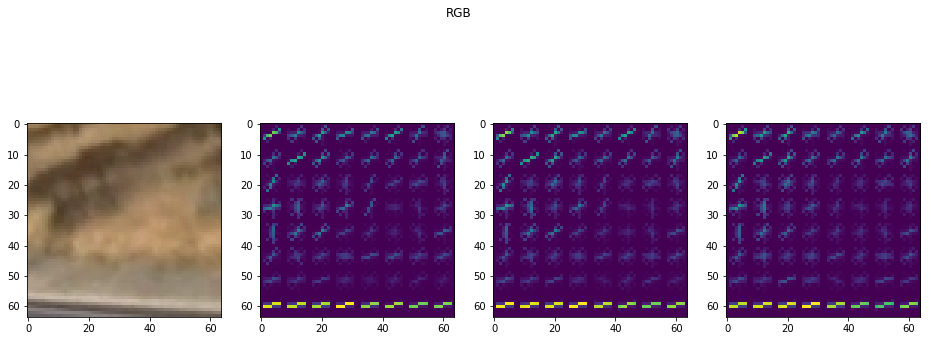

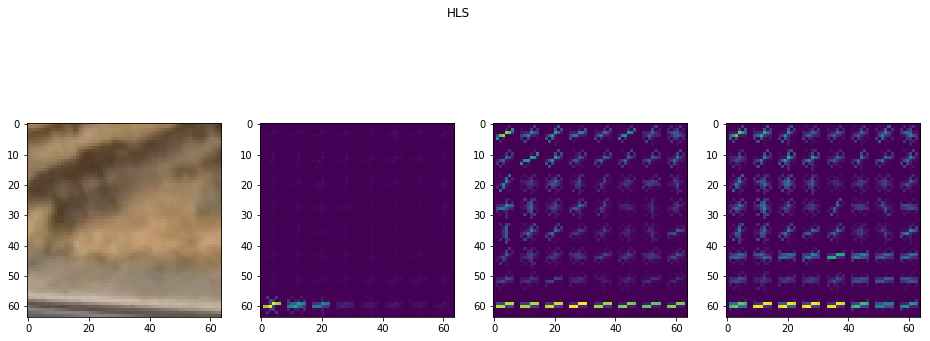

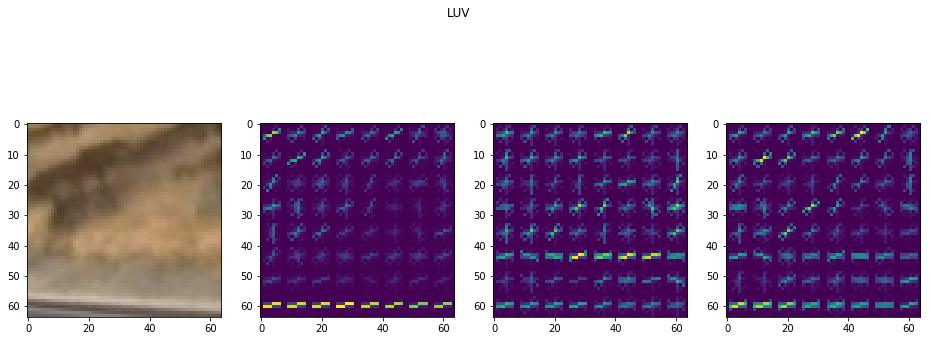

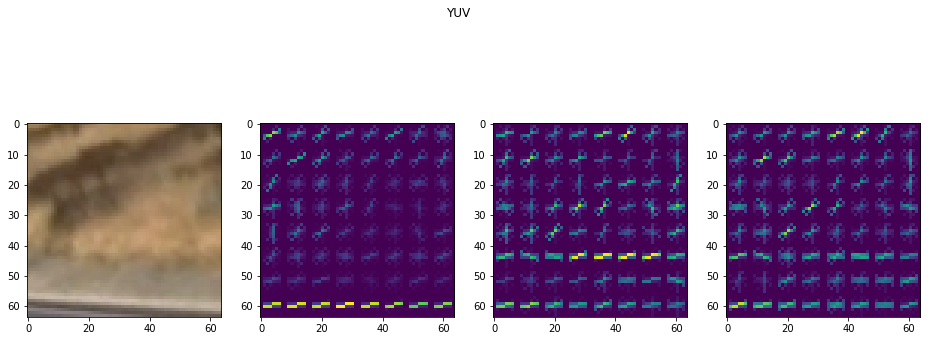

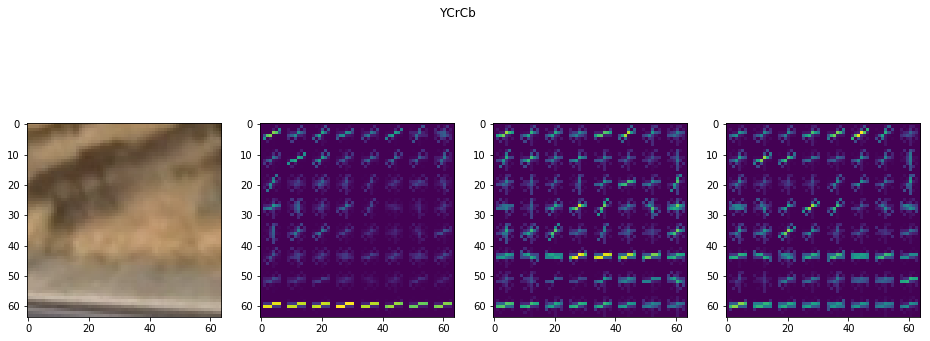

In [12]:
# Test the above function with a test image within a couple of color spaces
randImage = cv2.cvtColor(cv2.imread(train_imgs[random.randint(0, len(train_imgs))]), cv2.COLOR_BGR2RGB)

# Explore various color spaces for HOG gradient
color_spaces = ["RGB", "HLS", "LUV", "YUV", "YCrCb"]

for color_space in color_spaces:
    
    fig = plt.figure(figsize=(16,14))
    fig.suptitle(color_space)
    fig.add_subplot(3, 4, 1)
    plt.imshow(randImage)
    
    for channel in range(0, 3):
        fig.add_subplot(3, 4, 2 + channel)
        features, hog_image = get_hog_features(randImage, color_space=color_space, channel_index=channel, vis=True)
        plt.imshow(hog_image)

After testing several different colorspaces and parameters in later tests, YCrCb had the best result, so that's the one I'll be sticking with. Let's play with some parameters to get a better feel for what works.

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


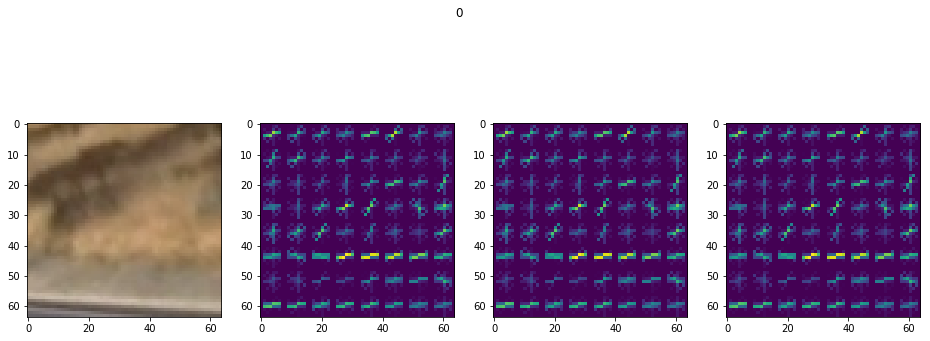

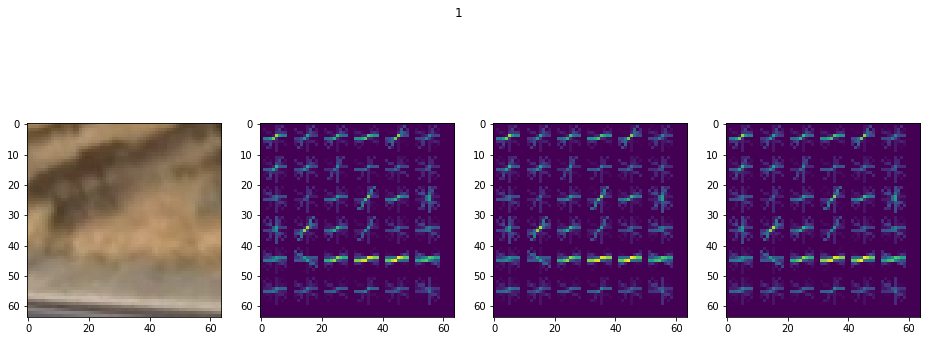

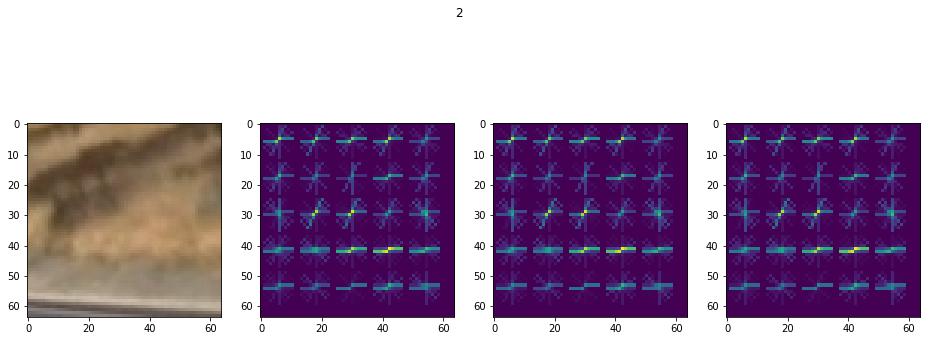

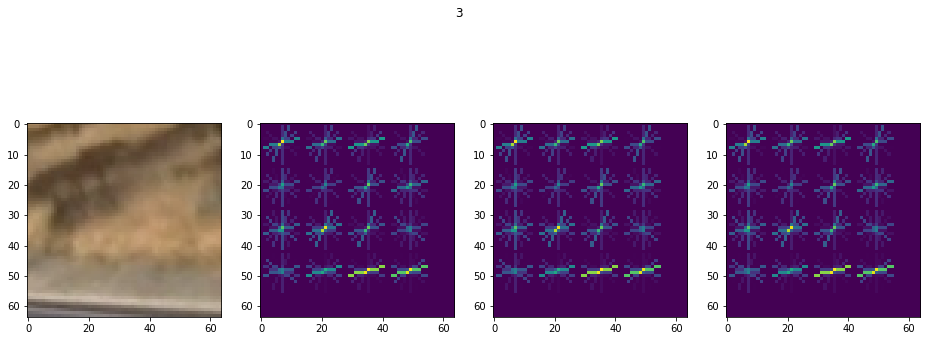

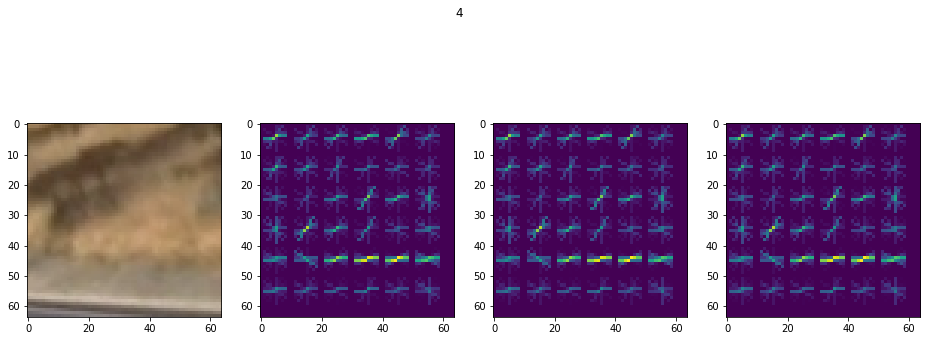

In [13]:
parameters = [
    {"orient": 9,  "pix_per_cell": 8,  "cell_per_block": 2},
    {"orient": 11, "pix_per_cell": 10, "cell_per_block": 2},
    {"orient": 11, "pix_per_cell": 12, "cell_per_block": 2},
    {"orient": 7,  "pix_per_cell": 14, "cell_per_block": 4},
    {"orient": 11, "pix_per_cell": 10, "cell_per_block": 4},]

for index, setting in enumerate(parameters):
    
    fig = plt.figure(figsize=(16,14))
    fig.suptitle(index)
    fig.add_subplot(3, 4, 1)
    plt.imshow(randImage)
    
    for channel in range(0, 3):
        fig.add_subplot(3, 4, 2 + channel)
        features, hog_image = get_hog_features(randImage, 
                                               orient=setting["orient"],
                                               pix_per_cell=setting["pix_per_cell"], 
                                               cell_per_block=setting["cell_per_block"],
                                               vis=True,
                                               color_space="YCrCb", 
                                               channel_index=1)
        plt.imshow(hog_image)
    

After a bit of testing, it appears the best results come with the settings: orientations=11, pix_per_cell=10, cell_per_block=4.

Next, let's build the dataset. To do this we'll use several image augmentations to help generalize the dataset, then normalize the dataset to keep the features balanced.

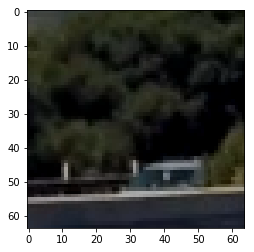

In [14]:
sample_image = cv2.cvtColor(cv2.imread(train_imgs[15]), cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)

In [15]:
def random_brightness(img):
    if random.randint(1, 2) == 2:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        # Brightness adjustment
        value = random.randint(50, 120)

        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
        return img
    else:
        how_dark = random.uniform(0.2, 0.7)
        black = np.zeros_like(img)
        return cv2.addWeighted(img, 1.0 - how_dark, black, how_dark, 0)

In [16]:
def random_augmentation(img):
    # Randomly adjust the brightness
    img = random_brightness(img)
    
    # Apply random noise
    row,col,ch = img.shape
    noise = (np.ones_like(img) * np.random.randn(row,col,ch).reshape(row,col,ch)).astype(np.uint8)
    noise_level = random.uniform(0.1, 0.3)
    img = cv2.addWeighted(img, 1 - noise_level, noise, noise_level, 0.0)
    
    # Apply random blur
    blur_amount = random.randrange(1, 10, 2)
    img = cv2.GaussianBlur(img, (blur_amount ,blur_amount), 0)
    
    # Randomly flip the image
    if random.randint(1, 2) is 2: img = cv2.flip(img, 1)
    return img

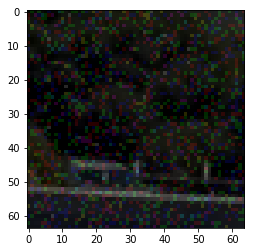

In [17]:
plt.imshow(random_augmentation(sample_image))

In [18]:
def convert_sample(img): 
    features = []
    features.append(bin_spatial(img, "HLS", channels_kept=["H", "S"]))
    features.append(bin_spatial(img, "HSV", channels_kept=["V"]))
    features.append(histograms(img, color_space="HLS", channels_kept=["H", "S"]))
    features.append(histograms(img, color_space="HSV", channels_kept=["V"]))    
    
    #Use features we determined earlier
    for channel_index in range(0, 3):
        hog = get_hog_features(img, 
                               color_space="YCrCb", 
                               channel_index=channel_index, 
                               orient=11, 
                               pix_per_cell=10, 
                               cell_per_block=4,
                               vis=False)
        hog = hog.ravel()
        features.append(hog)

    sample = np.concatenate(features)
    
    return sample

In [19]:
augmentations = 3

def convert_dataset(dataset, labels=None):
    converted = []
    converted_labels = []
    
    for index, data in enumerate(dataset):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        converted.append(convert_sample(img))
        
        if labels is not None:
            converted_labels.append(labels[index])

            for i in range(0, augmentations):
                augmented = random_augmentation(img)
                converted.append(convert_sample(augmented))
                converted_labels.append(labels[index])
        
    if labels is not None:
        return converted, converted_labels
    else:
        return converted

In [20]:
# train_features, train_labels = convert_dataset(train_imgs, labels=train_original_labels)
train_features = convert_dataset(train_imgs)
train_labels = train_original_labels
test_features = convert_dataset(test_imgs)

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[  8.20000000e+01   6.70000000e+01   6.10000000e+01 ...,   4.35145106e-03
   8.59204579e-04   0.00000000e+00]


/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


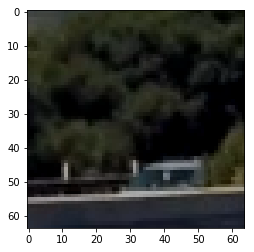

In [21]:
test = cv2.cvtColor(cv2.imread(train_imgs[15]), cv2.COLOR_BGR2RGB)
plt.imshow(test)
print(convert_sample(test))

In [22]:
# Normalize the data
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

In [23]:
def time_accuracy(classifier, name, train_features, train_labels, test_features, test_labels):
    t1 = time()
    classifier.fit(train_features, train_labels)
    t2 = time()
    print(name + " training time: " + str(round(t2-t1, 2)) + " seconds")
    t1 = time()
    print(name + " test accuracy: " + str(round(classifier.score(test_features, test_labels), 4)))
    t2 = time()
    print(name + " prediction time: " + str(round(t2-t1, 2)) + " seconds")

# Let's check the accuracy and execution time of Decision Trees
time_accuracy(DecisionTreeClassifier(), "Decision Tree", train_features, train_labels, test_features, test_labels)
time_accuracy(LinearSVC(), "Linear SVC", train_features, train_labels, test_features, test_labels)
time_accuracy(SVC(), "SVC", train_features, train_labels, test_features, test_labels)

Decision Tree training time: 133.41 seconds
Decision Tree test accuracy: 0.9736
Decision Tree prediction time: 0.04 seconds
Linear SVC training time: 3.62 seconds
Linear SVC test accuracy: 0.9932
Linear SVC prediction time: 0.03 seconds
SVC training time: 350.32 seconds
SVC test accuracy: 0.9966
SVC prediction time: 198.33 seconds


The Linear SVC is by far the fastest and only slightly less accurate than SVC. Interestingly, the Decision Tree was far slower and quite a bit less accurate than the Linear SVC.

In [24]:
# Let's check the confusion matrix to see how many false positives
# and false negatives we have with the Linear SVC. This is just to
# see if there is an extrmem imbalence in the predictions.
svc = LinearSVC()
svc.fit(train_features, train_labels)
print(confusion_matrix(svc.predict(test_features), test_labels))

[[2159   13]
 [  17 2251]]


As we can see, the false positives and false negatives are fairly close to each other, so their isn't much of an imbalance.

In [25]:
# Take an image and resize, convert, and normalize it to compare to the SVM
def vehicle_classifier(img):
    return svc.predict(scaler.transform([convert_sample(cv2.resize(img, (64,64)))]))[0]

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


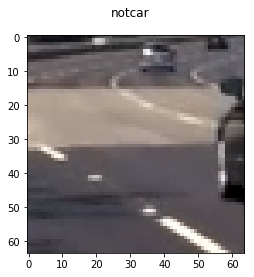

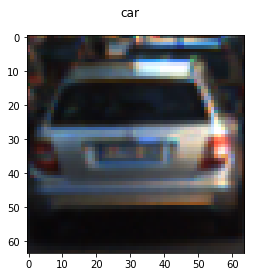

In [26]:
test = cv2.cvtColor(cv2.imread(train_imgs[12]), cv2.COLOR_BGR2RGB)
plt.figure()
plt.suptitle(vehicle_classifier(test))
plt.imshow(test)

test = cv2.cvtColor(cv2.imread(train_imgs[200]), cv2.COLOR_BGR2RGB)
plt.figure()
plt.suptitle(vehicle_classifier(test))
plt.imshow(test)

In [27]:
# Checking accuracy when flopping on low confidence
def getAccuracy(imgs, name, labels):
    t1 = time()
    predictions = []
    for img_filename in imgs:
        img = cv2.imread(img_filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predictions.append(vehicle_classifier(img))
    t2 = time()
    print("Time to predict for " + name + ": " + str(round(t2-t1, 2)) + " seconds.")
    print("Accuracy for " + name + ": " + str(accuracy_score(predictions, labels)))
    print("Confusion matrix for " + name + ": \n" + str(confusion_matrix(predictions, labels)))

In [28]:
getAccuracy(train_imgs, "training images", train_original_labels)
getAccuracy(test_imgs, "test images", test_labels)

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time to predict for training images: 55.41 seconds.
Accuracy for training images: 1.0
Confusion matrix for training images: 
[[6616    0]
 [   0 6704]]
Time to predict for test images: 17.61 seconds.
Accuracy for test images: 0.993243243243
Confusion matrix for test images: 
[[2159   13]
 [  17 2251]]


We can see the vehicle classifier is 100% accurate on the training set which is indicative of overfitting, and 99.32% on the test set, with false positives and negatives still fairly close to each other.

In [29]:
# Sliding windows search function, this returns the upper left and lower right 
# window coordinates given an area to start and stop with an overlap.
def sliding_windows(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop is not None: x_start_stop = list(x_start_stop)
    else: x_start_stop = [None, None]
        
    if y_start_stop is not None: y_start_stop = list(y_start_stop)
    else: y_start_stop = [None, None]

    if x_start_stop is None: x_start_stop = (0, img.shape[1])
    if x_start_stop[0] is None: x_start_stop[0] = 0
    if x_start_stop[1] is None: x_start_stop[1] = img.shape[1]
    
    if y_start_stop is None: y_start_stop = (0, img.shape[0])
    if y_start_stop[0] is None: y_start_stop[0] = 0
    if y_start_stop[1] is None: y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    yBuffer = np.int(xy_window[1]*(xy_overlap[1]))
    xBuffer = np.int(xy_window[0]*(xy_overlap[0]))
    nWindowsX = np.int((xspan - xBuffer)/nx_pix_per_step)
    nWindowsY = np.int((yspan - yBuffer)/ny_pix_per_step)

    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for yWindow in range(0, nWindowsY):
        for xWindow in range(0, nWindowsX):
            # Calculate each window position
            upperLeftY = (yWindow * ny_pix_per_step) + y_start_stop[0]
            upperLeftX = (xWindow * nx_pix_per_step) + x_start_stop[0]
            
            bottomRightY = upperLeftY + xy_window[1]
            bottomRightX = upperLeftX + xy_window[0]
            # Append window position to list
            window_list.append( ( (upperLeftX, upperLeftY), (bottomRightX, bottomRightY) ) )
    # Return the list of windows
    return window_list

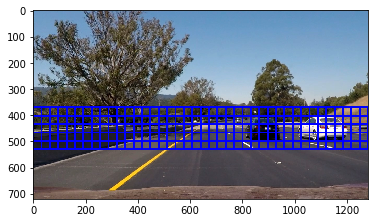

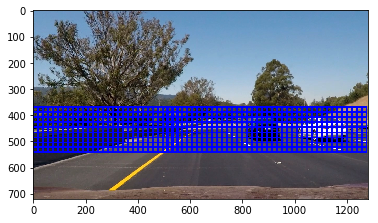

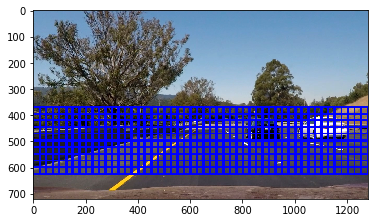

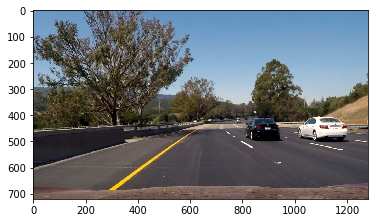

In [30]:
# Let's see how the sliding windows looks with various parameters
def showWindows(params):
    img = cv2.cvtColor(cv2.imread("./test_images/test6.jpg"), cv2.COLOR_BGR2RGB)
    windows = sliding_windows(img, 
                              x_start_stop = params["x_start_stop"], 
                              y_start_stop = params["y_start_stop"], 
                              xy_window = params["xy_window"], 
                              xy_overlap = params["xy_overlap"])
    for window in windows: cv2.rectangle(img, window[0], window[1], (0, 0, 255), 6)
    plt.figure()
    plt.imshow(img)
    plt.show()

ranges = [{"x_start_stop": None,
           "y_start_stop": (370, 550),
           "xy_window": (64,64),
           "xy_overlap": (0.5, 0.5)},
          {"x_start_stop": None,
           "y_start_stop": (370, 550),
           "xy_window": (96,96),
           "xy_overlap": (0.8, 0.8)}, 
          {"x_start_stop": None,
           "y_start_stop": (370, 625),
           "xy_window": (128,128),
           "xy_overlap": (0.8, 0.8)}, 
          {"x_start_stop": None,
           "y_start_stop": (370, 550),
           "xy_window": (196,196),
           "xy_overlap": (0.75, 0.75)}]

for i in range(len(ranges)): showWindows(ranges[i])


In [31]:
def scan_ranges(img):
    
    car_detections = []
    
    for area in ranges:
        windows = sliding_windows(img, 
                                  x_start_stop=area["x_start_stop"], 
                                  y_start_stop=area["y_start_stop"],
                                  xy_window=area["xy_window"], 
                                  xy_overlap=area["xy_overlap"])
        
        for window in windows:
            roi = img[window[0][1]:window[1][1],
                      window[0][0]:window[1][0]]
            classification = vehicle_classifier(roi)
            
            if classification == "car":
                car_detections.append(window)
                
    return car_detections

In [32]:
def draw_scanned_ranges(img, positive_windows, draw=True):
    for window in positive_windows:
        cv2.rectangle(img, window[0], window[1], (0, 0, 255), 6)
    
    if draw is True:
        plt.figure()
        plt.imshow(img)
        plt.show()
    else:
        return img

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


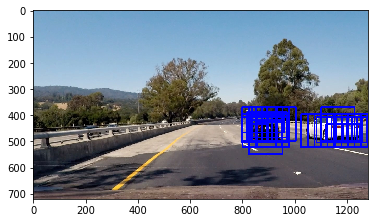

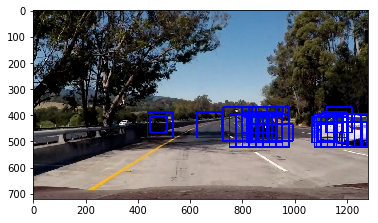

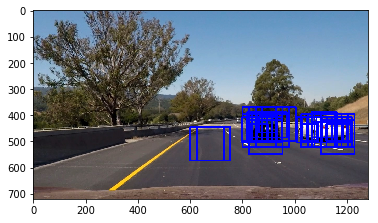

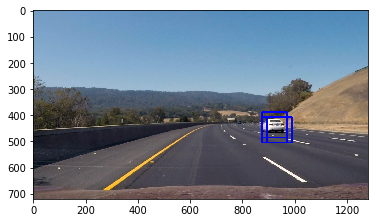

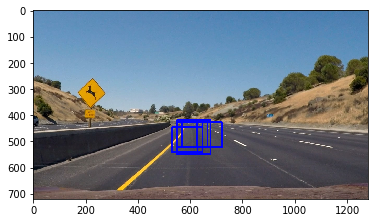

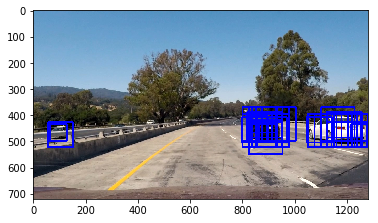

In [33]:
# Let's test out the sliding windows to identify cars

test_images = glob("./test_images/*.jpg")

for test_image in test_images:
    img = cv2.imread(test_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    car_detections = scan_ranges(img)
    draw_scanned_ranges(img, car_detections)

Notice there are some false positives. Let's use some heatmaps and thresholds to ignore the false positives.

In [34]:
def create_heatmap(img, detections):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    for detection in detections:
        heatmap[ detection[0][1]:detection[1][1] , detection[0][0]:detection[1][0] ] += 1
        
    return heatmap

def apply_heatmap_threshold(heatmap, threshold):
    heatmap_threshold = np.copy(heatmap)
    heatmap_threshold[ heatmap_threshold <= threshold ] = 0
    return heatmap_threshold

def bounding_boxes_from_heatmap(heatmap):
    #We need to do some work to convert the simple heatmaps into something that the blob detector can use.
    heatmap_8bit = np.copy(heatmap)
    heatmap_8bit *= 50
    heatmap_8bit = heatmap_8bit.astype(np.uint8)
    
    params = cv2.SimpleBlobDetector_Params()
    params.filterByInertia = False
    params.filterByConvexity = False
    detector = cv2.SimpleBlobDetector_create(params)
    
    return detector.detect(heatmap_8bit)

def bounding_boxes_from_heatmap(heatmap):
    labels, number_of_features = label(heatmap)
    
    bounding_boxes = []
    
    for feature_number in range(1, number_of_features + 1):
        # Find all items in the heatmap that map to a specific value/label
        nonzero = (labels == feature_number).nonzero()
        # The nonzero function returns a the (y,x) coords of where non zero functions exist
        # Since we isolated the value of the car we're looking at, we can work from there!
        x = np.array(nonzero[1])
        y = np.array(nonzero[0])
        
        bbox = ( (np.min(x), np.min(y)), (np.max(x), np.max(y)) )
        
        bounding_boxes.append(bbox)
        
    return bounding_boxes

/home/josh/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


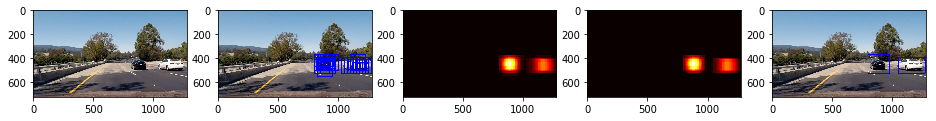

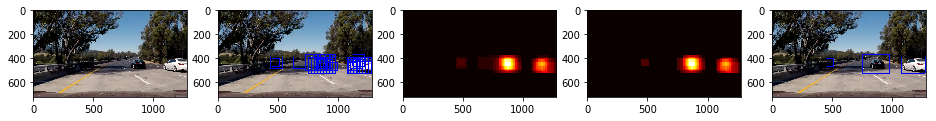

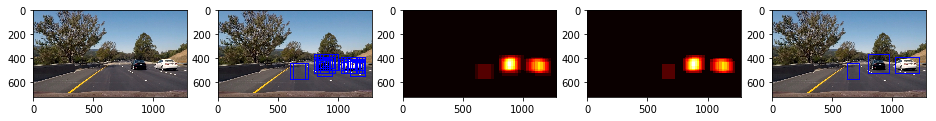

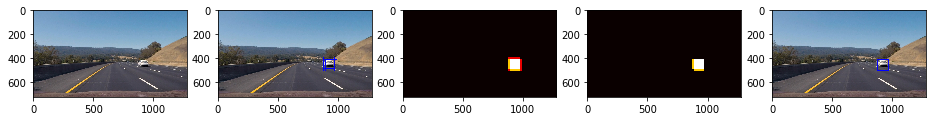

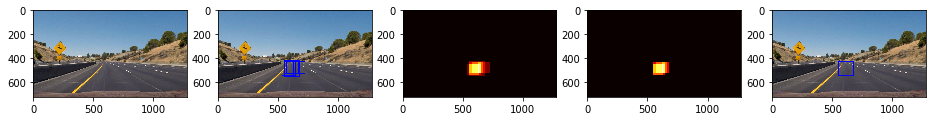

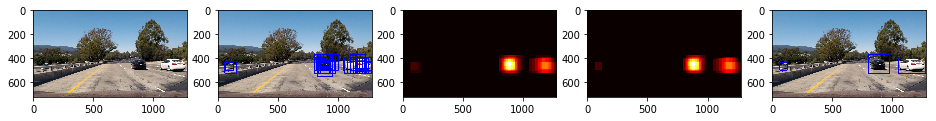

In [35]:
from glob import glob

test_images = glob("./test_images/*.jpg")

threshold = 1

heatmaps = []

for test_image in test_images:
    img =  cv2.imread(test_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_marked = img.copy()
    
    car_detections = scan_ranges(img)
    heatmap = create_heatmap(img, car_detections)
    heatmap_thresholded = apply_heatmap_threshold(heatmap, threshold)
    
    heatmaps.append(heatmap_thresholded)
    
    bounding_boxes = bounding_boxes_from_heatmap(heatmap_thresholded)
    for box in bounding_boxes:
        cv2.rectangle(img_marked, box[0], box[1], (0, 0, 255), 6)
        
    fig = plt.figure(figsize=(16,14))
    fig.add_subplot(2, 5, 1)
    plt.imshow(img)
    fig.add_subplot(2, 5, 2)
    plt.imshow(draw_scanned_ranges(img, car_detections, draw=False))
    fig.add_subplot(2, 5, 3)
    plt.imshow(heatmap, cmap='hot')
    fig.add_subplot(2, 5, 4)
    plt.imshow(heatmap_thresholded, cmap='hot')
    fig.add_subplot(2, 5, 5)
    plt.imshow(img_marked)

In [36]:
# Let's apply this pipeline to the project videos
from moviepy.editor import VideoFileClip

def test_process_frame(img):    
    car_detections = scan_ranges(img)
    heatmap = create_heatmap(img, car_detections)
    heatmap_thresholded = apply_heatmap_threshold(heatmap, threshold)
    
    bounding_boxes = bounding_boxes_from_heatmap(heatmap_thresholded)
    
    for box in bounding_boxes:
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
        
    return img

test_clip = VideoFileClip("./test_video.mp4")
output_clip = test_clip.fl_image(test_process_frame)
%time output_clip.write_videofile("./output_images/test_video_no_memory.mp4", audio=False)

pv_clip = VideoFileClip("./project_video.mp4")
output_clip = pv_clip.fl_image(test_process_frame)
%time output_clip.write_videofile("./output_images/project_video_no_memory.mp4", audio=False)

[MoviePy] >>>> Building video ./output_images/test_video_no_memory.mp4
[MoviePy] Writing video ./output_images/test_video_no_memory.mp4


 97%|█████████▋| 38/39 [01:48<00:02,  2.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_no_memory.mp4 

CPU times: user 1min 48s, sys: 152 ms, total: 1min 48s
Wall time: 1min 49s
[MoviePy] >>>> Building video ./output_images/project_video_no_memory.mp4
[MoviePy] Writing video ./output_images/project_video_no_memory.mp4


100%|█████████▉| 1260/1261 [57:52<00:02,  2.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_no_memory.mp4 

CPU times: user 57min 50s, sys: 1.61 s, total: 57min 51s
Wall time: 57min 54s


The car tracking works decently well. There is a spot in the center of the frame that conisistenly has bounding boxes around it despite there being nothing but road there. Hopefully adding a memory for the tracking will help as well as minimize the jitteriness of the bounding boxes. This will be done with the creation of a new car class. This car class will simplify the processing for the videos by keeping everything organized.

In [37]:
cars = []
class Car:
    
    def __init__(self, bounding_box = None):
        global cars
        
        self.name = "Car-" + str(len(cars) + 1)
        
        self.bounding_box = bounding_box # Current bounding box
        self.speed = 0
        
        #Hold prior information about the car
        self.prior_bounding_boxes = []
        
        # Hold this car's age in frames
        self.age = 1
        
        # last_seen is what relative frame the car was last seen
        self.last_seen = 1
        
        # self.seen is whether or not a bounding box was observed during processing this frame
        self.seen = False
        
        # draw is whether or not the bounding box should be drawn
        self.draw = self.bounding_box is not None
        
    # Determine if  bounding boxes overlap, indicating it is one vehicle
    def overlap(self, bounding_box):
        current_box = self.bounding_box if self.bounding_box is not None else self.prior_bounding_boxes[-1]
        
        left = max(current_box[0][0], bounding_box[0][0])
        right = min(current_box[1][0], bounding_box[1][0])
        bottom = min(current_box[1][1], bounding_box[1][0])
        top = max(current_box[0][1], bounding_box[0][1])
        
        return left < right and bottom > top
    
    # Check nearby bounding boxes to see if they're part of the same vehicle
    def nearby(self, bounding_box):
        distance = 20 # minimum pixels to consider part of the same car
    
        new_bounding_box = [ (bounding_box[0][0] - 20, bounding_box[0][1] - 20), (bounding_box[1][0] + 20, bounding_box[1][1] + 20) ]
        
        return self.overlap(new_bounding_box)
                
    # should_combine is a true/false function that says whether or not the bounding boxes should be combined
    # uses both overlap and nearby functions
    def should_combine(self, bounding_box):
        return self.overlap(bounding_box) or self.nearby(bounding_box)
    
    # combine is a function that, given a current bounding_box and the car's current,
    # shall recalculate the current bounding box based on magnitude (size) of bounding boxes
    def combine(self, bounding_box):
        # If there is no bounding box, this BECOMES the bounding box
        if self.bounding_box is None:
            if len(self.prior_bounding_boxes) >= 1:
                self.bounding_box = self.prior_bounding_boxes[-1]
                self.combine(bounding_box)
            else:
                self.bounding_box = bounding_box
        else:
            jitter = 0.1 # Proportion of prior value to minimize jitter
            
            self.bounding_box = ((int(self.bounding_box[0][0] + (bounding_box[0][0] - self.bounding_box[0][0]) * jitter), 
                                  int(self.bounding_box[0][1] + (bounding_box[0][1] - self.bounding_box[0][1]) * jitter)),
                                 (int(self.bounding_box[1][0] + (bounding_box[1][0] - self.bounding_box[1][0]) * jitter), 
                                  int(self.bounding_box[1][1] + (bounding_box[1][1] - self.bounding_box[1][1]) * jitter)))
    
    # Time to determine if a car should be forgotten
    def should_die(self):
        if self.age < 32:
            return False
        return self.age - self.last_seen >= 10
    
    def draw_bounding_box(self, img):
        box = self.bounding_box if self.bounding_box is not None else self.prior_bounding_boxes[-1]        
        cv2.rectangle(img, box[0], box[1], (0, 255, 0), 6)
        
    # returns if the frame is old enough to be seen
    def old_enough(self):
        return self.age >= 32 and len(self.prior_bounding_boxes) >= 25
    
    def generate_ranges(self, frame):
        current_ranges = []
        
        #First, build a range the size of the current bounding box, + 10pixels for margin
        current_box = self.bounding_box if self.bounding_box is not None else self.prior_bounding_boxes[-1]
        
        current_box = ((max(current_box[0][0] - 10, 0), 
                        max(current_box[0][1] - 10, 0)),
                       (min(current_box[1][0] + 10, frame.shape[1]), 
                        min(current_box[1][1] + 10, frame.shape[0])))
        
        x_start_stop = (max(current_box[0][0] - 50, 0), min(current_box[1][0] + 50, frame.shape[1]))
        y_start_stop = (max(current_box[0][1] - 50, 0), min(current_box[1][1] + 50, frame.shape[0]))
        
        current_ranges=[{"x_start_stop": x_start_stop,
                         "y_start_stop": y_start_stop,
                         "xy_window": (max(current_box[1][0] - current_box[0][0] - 32, 128),
                                       max(current_box[1][1] - current_box[0][1] - 32, 128)),
                         "xy_overlap": (0.8, 0.8)},
                        {"x_start_stop": x_start_stop, 
                         "y_start_stop": y_start_stop,
                         "xy_window": (128, 128),
                         "xy_overlap": (0.8, 0.8)},
                        {"x_start_stop": x_start_stop,
                         "y_start_stop": y_start_stop,
                         "xy_window": (96, 96),
                         "xy_overlap": (0.8, 0.8)},
                        {"x_start_stop": x_start_stop,
                         "y_start_stop": y_start_stop,
                         "xy_window": (64, 64),
                         "xy_overlap": (0.8, 0.8) }]
        
        return current_ranges
        
    def scan_ranges(self, frame):
        car_detections = []
    
        for area in self.generate_ranges(frame):
            windows = sliding_windows(img, x_start_stop=area["x_start_stop"], y_start_stop=area["y_start_stop"], 
                        xy_window=area["xy_window"], xy_overlap=area["xy_overlap"])

            for window in windows:
                roi = frame[ window[0][1] : window[1][1] , window[0][0] : window[1][0] ]
                classification = vehicle_classifier(roi)

                if classification == "vehicle":
                    car_detections.append(window)

        return car_detections
    
    # Slide windows scan over a car
    def scan_over_car(self, frame):
        car_detections = self.scan_ranges(frame)
        heatmap = create_heatmap(frame, car_detections)
        threshold = 5
        heatmap_thresholded = apply_heatmap_threshold(heatmap, threshold)
        bounding_boxes = bounding_boxes_from_heatmap(heatmap_thresholded)
        
        if len(bounding_boxes) is 0:
            return
        
        for bbox in bounding_boxes:
            self.combine(bbox)
        
    # Tick advances time for each car tracker
    def tick(self):
        self.age += 1
        
        if self.bounding_box is not None:
            self.prior_bounding_boxes.append(self.bounding_box)

        self.bounding_box = None
        self.seen = False
    
    # Tock is called after tick, after all processing 
    def tock(self):
        if self.bounding_box is None:
            # We don't see this car anymore - don't increment last_seen!
            # this is me not doing that thing
            
            # Calculate whether we should be "seen"
            self.seen = not self.should_die() and self.old_enough()
            
        else:
            # We see this car, so increment it's last_seen
            self.last_seen = self.age
            
            # Set seen if we're old enough and we have enough prior frames of info
            self.seen = self.old_enough()
            

Let's test the sliding window search around the car and see how it performs.

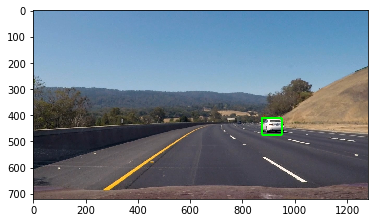

In [38]:
test_image = cv2.cvtColor(cv2.imread("./test_images/test3.jpg"), cv2.COLOR_BGR2RGB)

test_image_write = test_image.copy()
car_init = [(875, 410), (950, 475)] # initial car location
car = Car(car_init)
car.draw_bounding_box(test_image_write)
plt.figure()
plt.imshow(test_image_write)

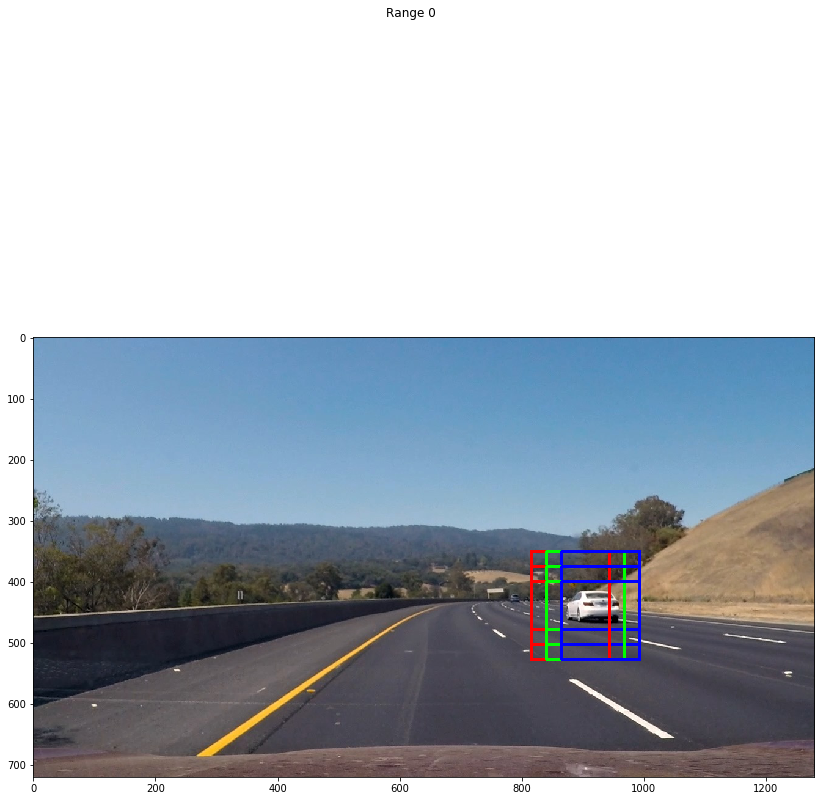

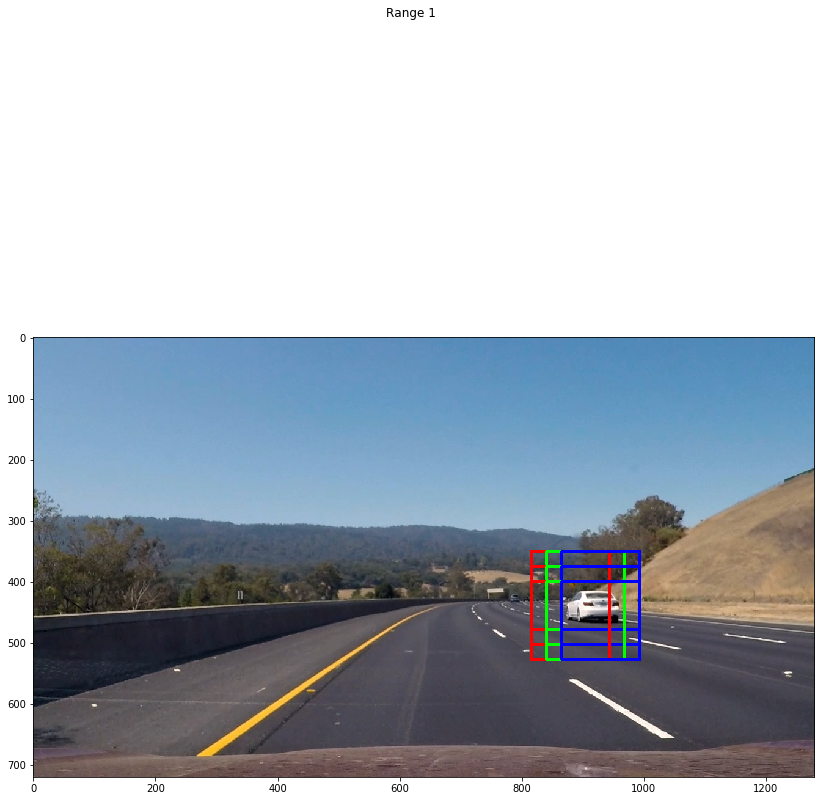

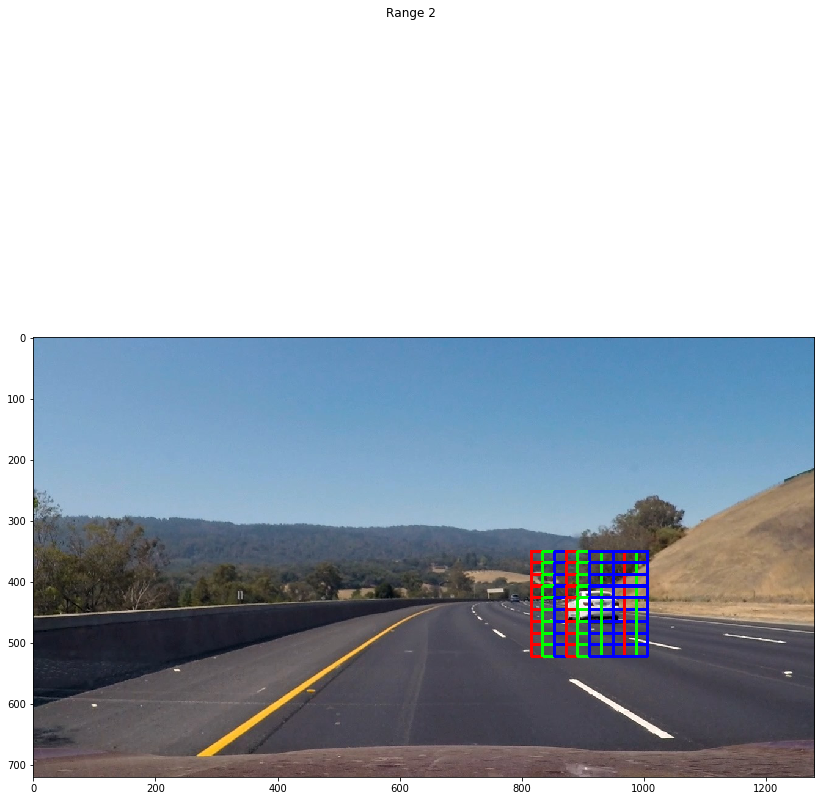

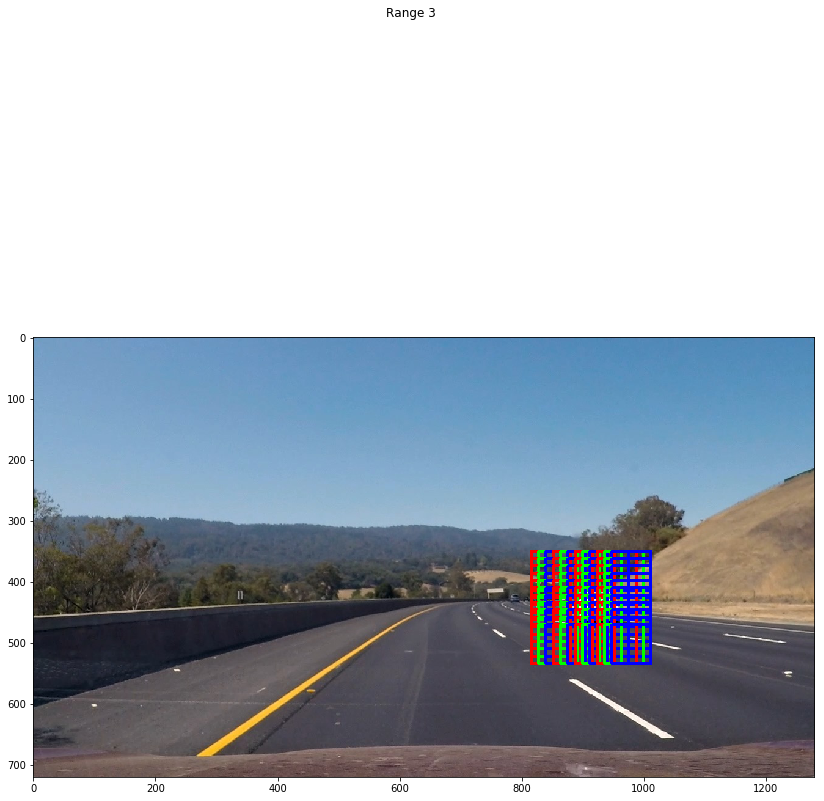

In [39]:
test_ranges = car.generate_ranges(test_image)

for index, area in enumerate(test_ranges):
    test_image_scan = test_image.copy()
    
    windows = sliding_windows(test_image_scan, x_start_stop=area["x_start_stop"], y_start_stop=area["y_start_stop"], 
                        xy_window=area["xy_window"], xy_overlap=area["xy_overlap"])

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = 0
    for window in windows:
        color = colors[color_index]
        color_index += 1
        if color_index >= len(colors):
            color_index = 0
            
        cv2.rectangle(test_image_scan, window[0], window[1], color, 3)
        
    plt.figure(figsize=(14,16))
    plt.suptitle("Range " + str(index))
    plt.imshow(test_image_scan)
    plt.show()

0  detections


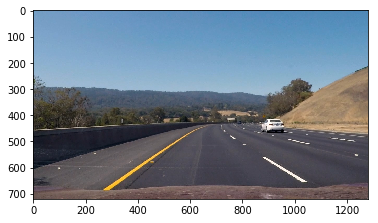

In [40]:
detections = car.scan_ranges(test_image)

test_image_detects = test_image.copy()

print(len(detections), " detections")

for detection in detections:
    cv2.rectangle(test_image_detects, detection[0], detection[1], (0, 0, 255), 3)
    
plt.imshow(test_image_detects)

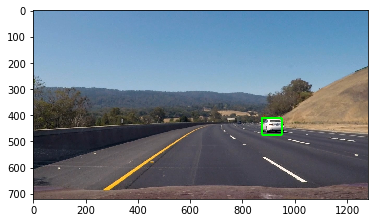

In [42]:
# This test is testing the result of the heatmap scan and playing with the threshold
scan_test = test_image.copy()

car.scan_over_car(scan_test)

car.draw_bounding_box(scan_test)

plt.figure()
plt.imshow(scan_test)

In [43]:
cars = []
frame_count = 0

def pipeline(frame):
    global cars
    global frame_count
    
    frame_count += 1
    
    # Go through every car and initiate the "tick" - start of processing step
    for car in cars:
        car.tick()
        
    # For each car, do a scan of just that car - but only if its old enough to be seen
    # within its agespan
    for car in cars:
        car.scan_over_car(frame)
        
    # Only scan everything 5th frame
    if frame_count % 5 == 0:
        # Go through the frame image, and produce the detection windows
        car_detections = scan_ranges(frame)
        heatmap = create_heatmap(frame, car_detections)
        heatmap_threshold = apply_heatmap_threshold(heatmap, threshold)
        bounding_boxes = bounding_boxes_from_heatmap(heatmap_threshold)
        
        for box in bounding_boxes:
            # For every box, let's see if it should be combined with current cars
            used = False
            for car in cars:
                if car.should_combine(box):
                    car.combine(box)
                    used = True
                    break
            if not used:
                car = Car(box)
                cars.append(car)
            
    # Now that we've created / updated all cars, tock them
    for car in cars:
        car.tock()
    
    # Remove cars that should die post tock
    # not efficient, but I was just trying to do this quickly. forgive me.
    for car in list(cars): #use list() to create a copy so we can remove while iterating
        if car.should_die():
            cars.remove(car)
    
    # If the cars overlap, produce a singular larger box
    for car in cars:
        if car.seen is False:
            continue
            
        for check_car in cars:
            if check_car.name == car.name:
                continue
            elif check_car.seen is False:
                continue
            else:
                current_box = car.bounding_box if car.bounding_box is not None else car.prior_bounding_boxes[-1]
                if current_box is None:
                    continue
                if check_car.should_combine(current_box):
                    check_car.seen = False
                    
                    car_box = car.bounding_box if car.bounding_box is not None else car.prior_bounding_boxes[-1]
                    check_box = check_car.bounding_box if check_car.bounding_box is not None else check_car.prior_bounding_boxes[-1]
                    
                    car_left_x = min(car_box[0][0], check_box[0][0])
                    car_left_y = min(car_box[0][1], check_box[0][1])
                    car_right_x = max(car_box[1][0], check_box[1][0])
                    car_right_y = max(car_box[1][1], check_box[1][1])
                    
                    car.bounding_box = [ (car_left_x, car_left_y), (car_right_x, car_right_y) ]
        
    # Draw a bounding box for each car now if it should be drawn
    for car in cars:
        if car.seen:
            car.draw_bounding_box(frame)

    #Return the drawn frame!
    return frame
        

In [44]:
cars = []
pv_clip = VideoFileClip("./project_video.mp4")
output_clip = pv_clip.fl_image(pipeline)
%time output_clip.write_videofile("./output_images/project_video.mp4", audio=False)

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


100%|█████████▉| 1260/1261 [1:20:36<00:03,  3.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 1h 20min 33s, sys: 1.61 s, total: 1h 20min 35s
Wall time: 1h 20min 37s
